# Classification of Parkinsson patients from EEG signals #
Ekaterina Lavrova 

## Import Packages ##

In [1]:
#import packages 
import os
import numpy as np
import pandas as pd 
import mne 
from mne.preprocessing import ICA
from scipy.signal import welch 
from sklearn.metrics import accuracy_score,recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import LeaveOneOut 

 ## Import Data ##

In [3]:
#import data
file_path = "C:/Users/katja/Programing_project/Data" 
raw_list = []

for file in os.listdir(file_path):
    raw = mne.io.read_raw_bdf(os.path.join(file_path,file), preload = True,verbose = False) 
    raw_list.append(raw)

## Filtering ##

Using matplotlib as 2D backend.


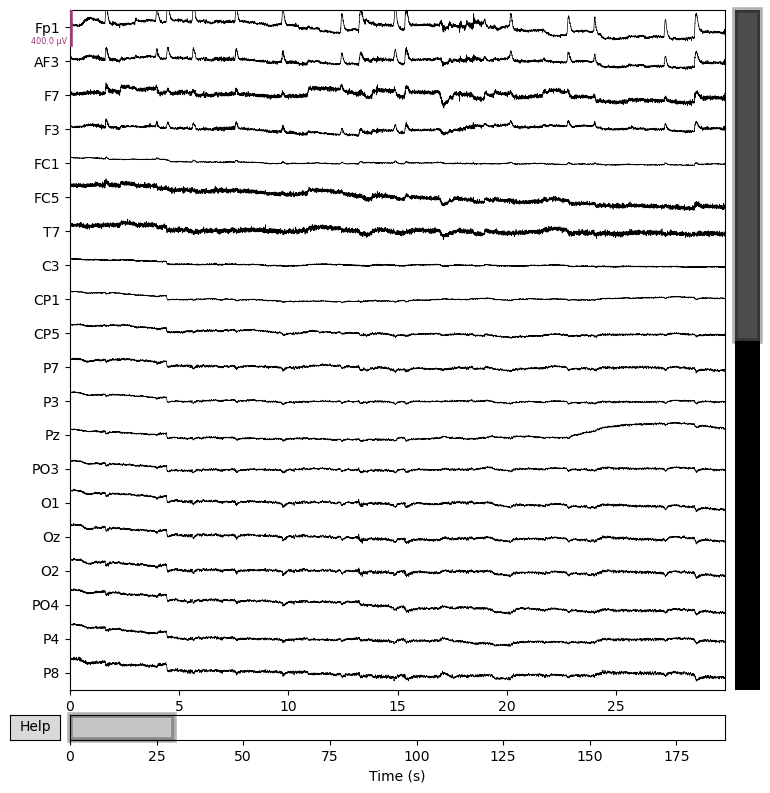

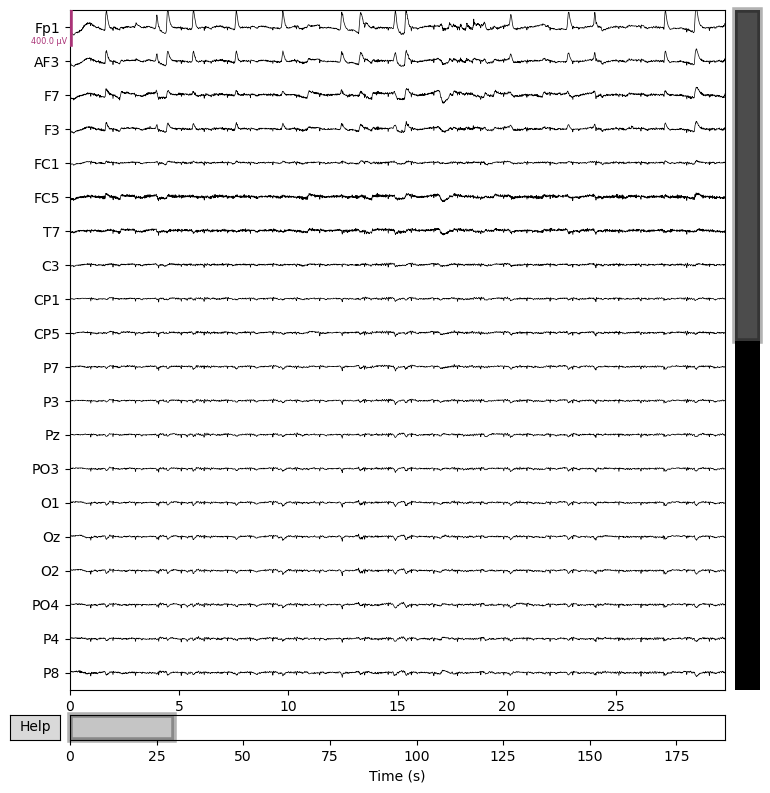

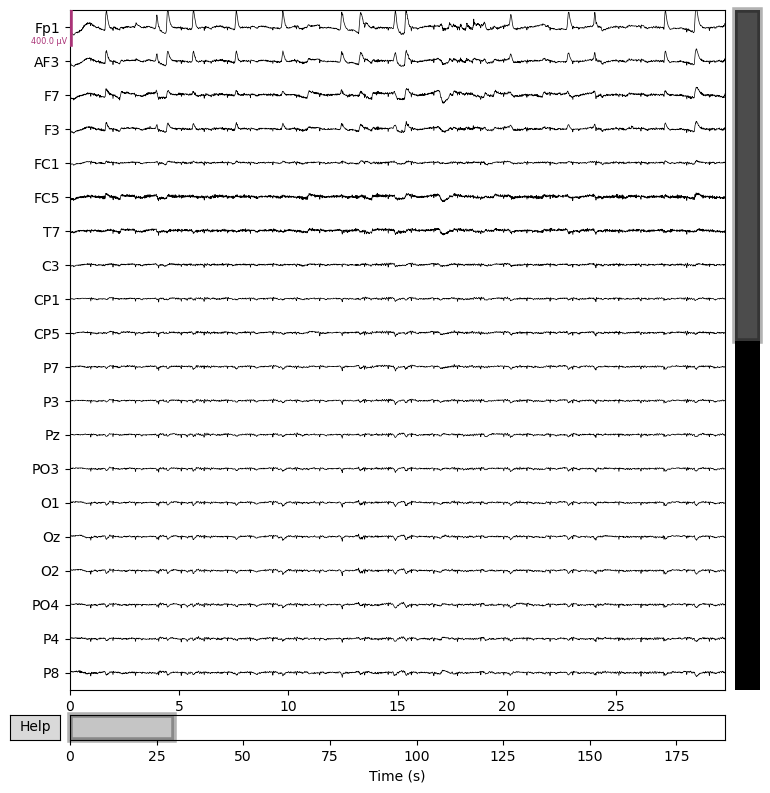

In [5]:
#Filtering 
raw_test = raw_list[4]
raw_test.plot(start = 0, duration = 30,scalings = dict(eeg=200e-6)) # Sclaed plot of file with index 1 

for raw in raw_list: 
    raw.filter(1.0,40.0, verbose = False) # Bandpass filtering 
    raw.notch_filter(50.0, verbose = False) # Notch filtering ( 50 Hz european standards, change to 60 Hz in USA)
    raw.set_eeg_reference('average', verbose = False) #Rereferencing using average method

raw_test.plot(start = 0, duration = 30,scalings = dict(eeg=200e-6)) #Plot after filtering

## Prepare ICA and data for artifact removal ##

In [7]:
ica_list = [] #Empty list for ICA components 

for raw in raw_list:
    montage = mne.channels.make_standard_montage('standard_1020') # Give channels positions according to the 10 20 system 

    # Mark EXG channels as NA 
    raw.set_channel_types({
        'EXG1':'misc', 'EXG2':'misc', 'EXG3':'misc', 'EXG4':'misc',
        'EXG5':'misc', 'EXG6':'misc', 'EXG7':'misc', 'EXG8':'misc'
    })
    raw.set_montage(montage)

# Configure and fit ICA to the data
for raw in raw_list:
    ica = ICA(n_components=15, method='fastica', random_state=42, verbose = False)
    ica.fit(raw, verbose = False )
    ica_list.append(ica)

C:\Users\katja\AppData\Local\Temp\ipykernel_50248\1462299793.py:7: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8 has changed from V to NA.
  raw.set_channel_types({
C:\Users\katja\AppData\Local\Temp\ipykernel_50248\1462299793.py:7: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8 has changed from V to NA.
  raw.set_channel_types({
C:\Users\katja\AppData\Local\Temp\ipykernel_50248\1462299793.py:7: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8 has changed from V to NA.
  raw.set_channel_types({
C:\Users\katja\AppData\Local\Temp\ipykernel_50248\1462299793.py:7: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8 has changed from V to NA.
  raw.set_channel_types({
C:\Users\katja\AppData\Local\Temp\ipykernel_50248\1462299793.py:7: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8 has changed from V to 

## Plot ICA components to identify artifacts ##

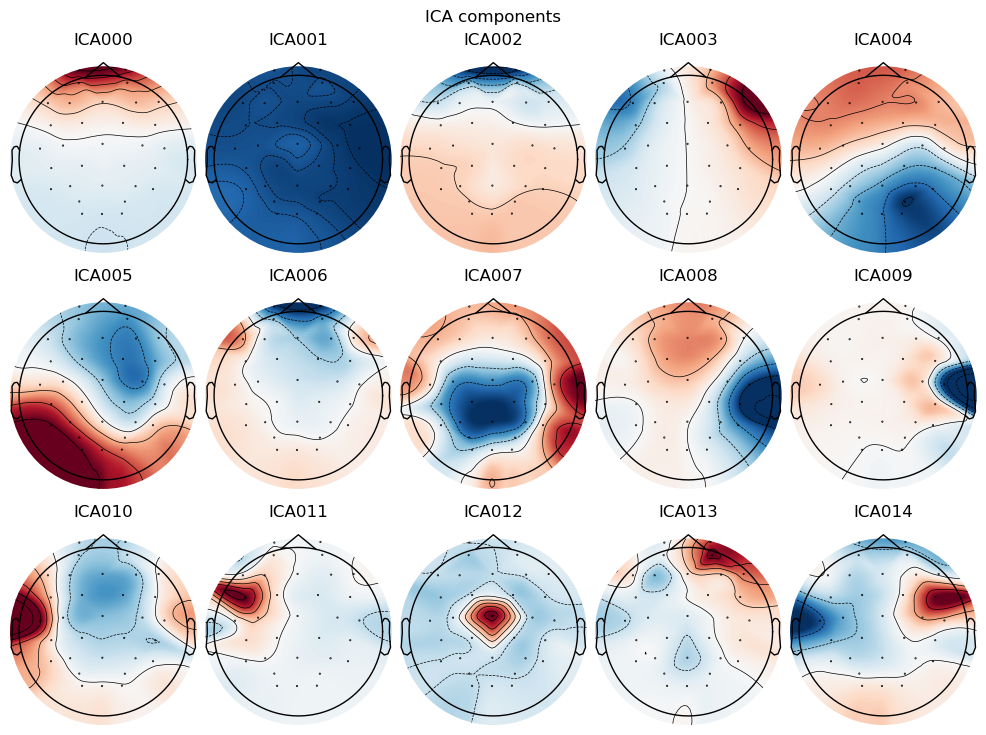

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components


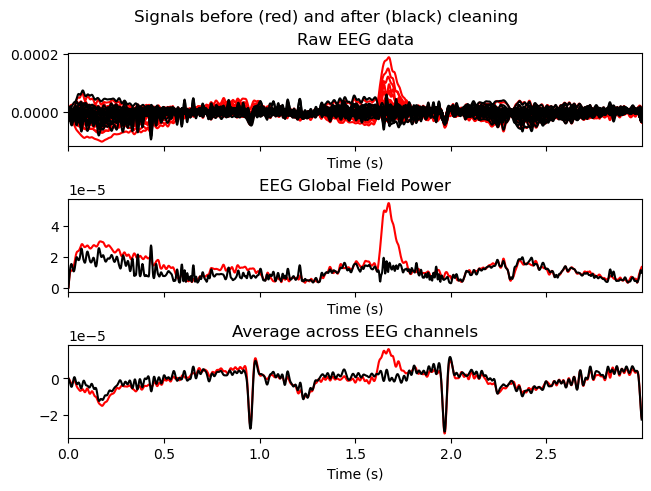

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components


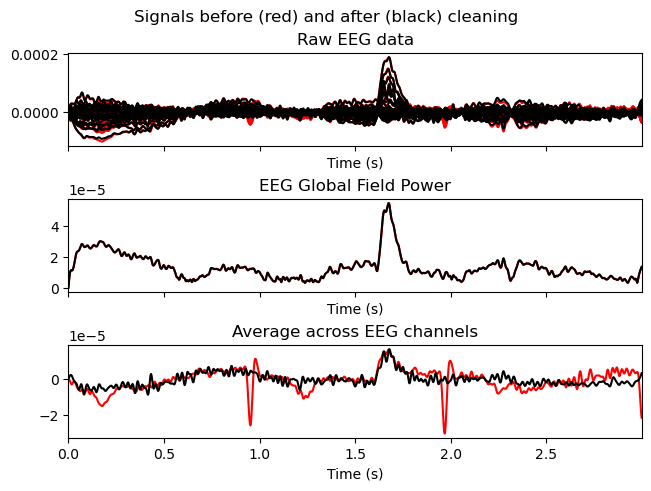

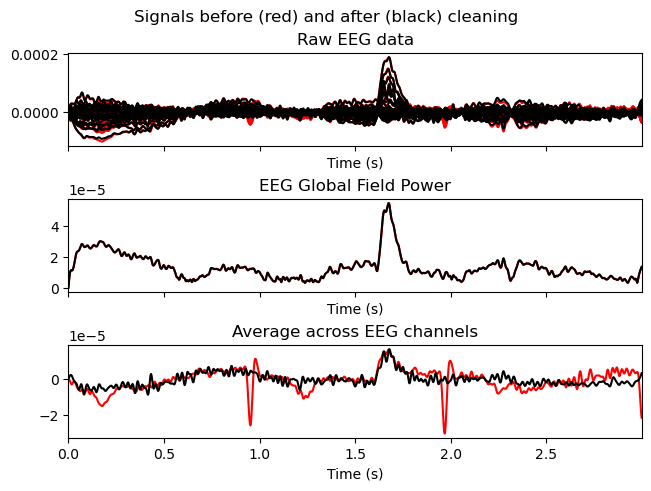

In [9]:
# Creates variable  that only include one file
raw_test = raw_list[4]
ica_test = ica_list[4]

# Plot components of one file 
ica_test.plot_components()

# Plot overlay of raw signal with specific ICA components excluded for one file 
ica_test.plot_overlay(raw_test, exclude=[0])  # exclude component 0 in file idx 1
ica_test.plot_overlay(raw_test, exclude=[1])  # exclude component 1 in file idx 1

## Apply ICA filtering to remove artifacts ## 

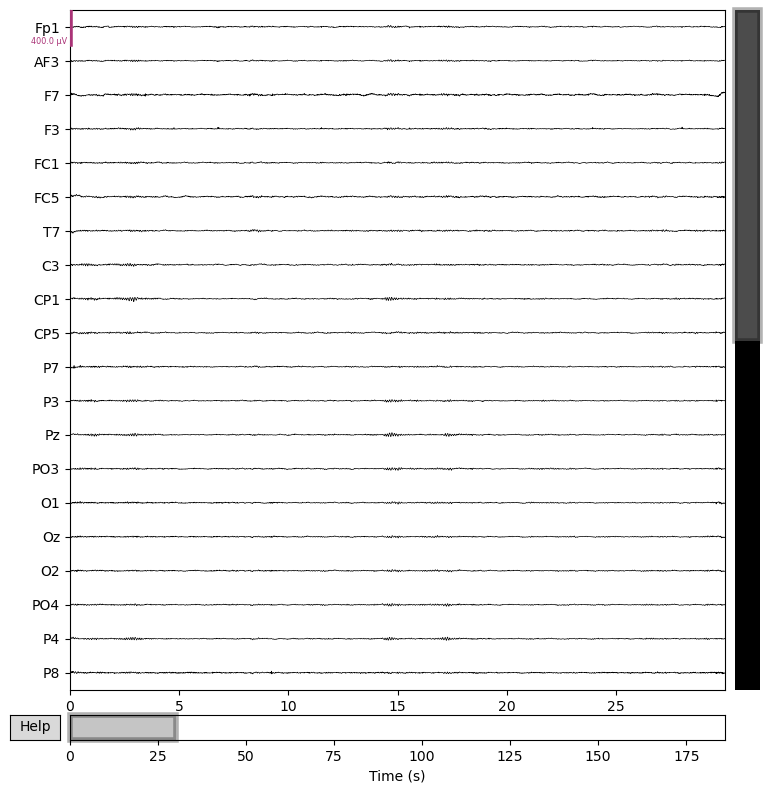

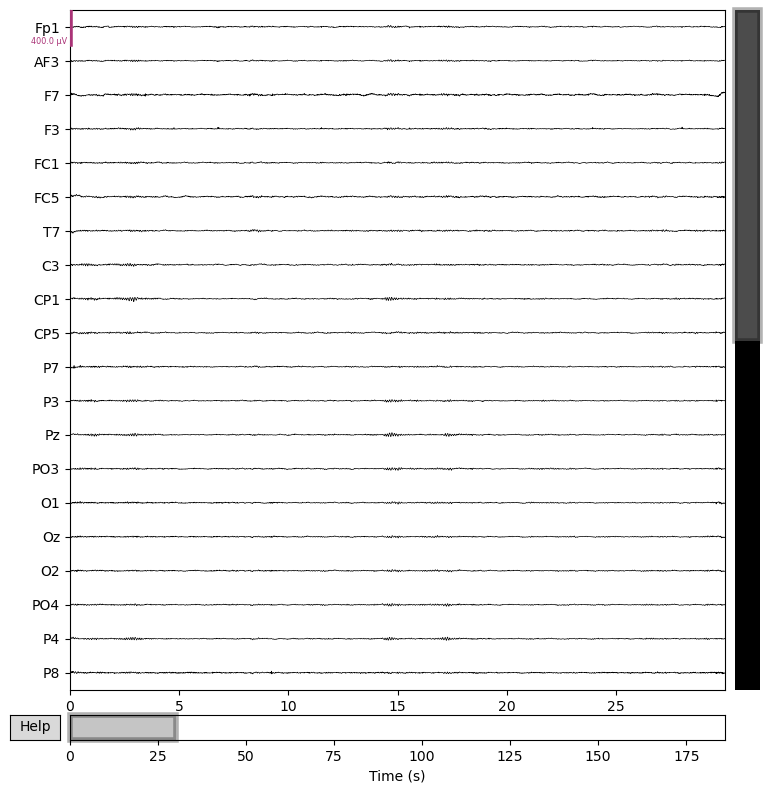

In [13]:
#Apply ICA filtering 
processed_raw = []

#Combine ICA and and the raw datafiles 
for ica, raw in zip(ica_list, raw_list):
    ica.exclude = [0,1] #exclude components 

    raw_clean = ica.apply(raw.copy(), verbose = False) #Create copies of each raw file xith ica applied 
    processed_raw.append(raw_clean) # add raw_copies to list

# Plot one fiel from the processed list to compare with unfiltered plot
raw = processed_raw [1]
raw.plot (start = 0, duration = 30, scalings=dict(eeg=200e-6))

## Defining Feature Functions ##

In [15]:

#Computing shannon entropy 
def shannon_entropy(signal):
    pdf, _ = np.histogram(signal, bins=50, density=True)
    pdf = pdf[pdf > 0]
    return -np.sum(pdf * np.log2(pdf))

#Computing bandpower 
def compute_bandpowers(signal, sfreq):
    freqs, psd = welch(signal, sfreq, nperseg=len(signal))

#Defining band frequencies 
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 12),
        'beta':  (12, 30),
        'gamma': (30, 45)
    }

    bp = {}
    for band, (low, high) in bands.items(): #Looping through bands to define frequency range 
        idx = (freqs >= low) & (freqs <= high) #boolean array indicating if the frequencies in the segment fall inside a specific frequency band 
        bp[band] = np.trapz(psd[idx], freqs[idx]) # Calculates psd for the frequencies in the specific band and segment 
    return bp

## Apply feature extraction ##

In [17]:
#Initiating empty list for features 
subject_features = []

file_path = "c:\\Users\\katja\\Programing_project\\Data" #Indicate file path to datafiles 

files = [file for file in os.listdir(file_path) ] #Iterate over files in file path and save filename in "files"

# Pair each processed file with its' filename and assign a group and subject based on the file name 
for raw_clean, file in zip(processed_raw, files):
    group = "healthy" if "sub-hc" in file else 'pd' # if filename contains "sub-hc" assign to healthy
    subject = file.split('_')[0].replace('sub-','') # Keep everything before _ in file name and remove the "sub" letters to get subject
    
    #Epoch the data 
    epochs =mne.make_fixed_length_epochs(
        raw_clean, 
        duration = 20, # 20 second epochs 
        preload = True, # save in RAM to be able to edit files 
        verbose = False)
    
    #Extract epochs to data 
    data = epochs.get_data()

    subject_epoch_features =[] #Initiate empry list to keep features before averaging 
    
    for i in range(data.shape[0]): # for epoch in epochs of data 
        for ch in range (data.shape[1]): # for channels in channels of data
            segments = data[i, ch, :] # segment the data extracting one epoch and one channel from that epoch including all its timepoints 

            # Skip segments which have 0 or NAN as standard deviation 
            std = np.std(segments)
            if std == 0 or np.isnan(std):
                continue 
            else:
                segments = (segments - np.mean(segments))/np.std(segments) #Normalize (Z-score)

            # Apply features using function 
            entropy_values = shannon_entropy(segments) 
            bp_values = compute_bandpowers(segments , raw_clean.info['sfreq'])

            #Store the data as a dictionary (except bandpowers)
            featured_data = {
                "entropy" : entropy_values,
                "group": group,
                "subject": subject
            }

            # Store bandpowers in featured_data dictionary 
            featured_data.update(bp_values)
            subject_epoch_features.append(featured_data) # Append dictonary content to the second initiated list 

    #Create dataframe from list  
    df_epochs = pd.DataFrame(subject_epoch_features)

    #Average the segmented data per subject 
    df_mean = df_epochs.groupby(
        ["subject", "group"]).mean(numeric_only = True).reset_index() # indicate to only use numeric data for averaging 
    
    subject_features.append(df_mean) # Append to firstly initiated list 

# Create final data frame and concatinate to get subject labels on y axis and feature labels on x axis 
df_subject = pd.concat(subject_features, ignore_index = True)
df_subject.to_csv("features_new_EEG.csv", index = False) # Save data frame as CSV 
print(df_subject) # Investigate the data

   subject    group    entropy     delta     theta     alpha      beta  \
0     hc10  healthy  11.937721  0.333868  0.099597  0.125064  0.347768   
1     hc18  healthy  10.898632  0.330642  0.093060  0.261358  0.181752   
2      hc1  healthy  11.612279  0.392384  0.070657  0.140218  0.295277   
3     hc20  healthy  12.774941  0.399008  0.145435  0.089265  0.225089   
4     hc21  healthy  11.689453  0.373664  0.076719  0.216644  0.206619   
5     hc24  healthy  11.812933  0.313769  0.110057  0.264057  0.196523   
6     hc25  healthy  12.147870  0.362497  0.096530  0.075080  0.294505   
7     hc29  healthy  12.276965  0.269072  0.092026  0.362668  0.205454   
8      hc2  healthy  11.548646  0.382920  0.104308  0.157513  0.251807   
9     hc30  healthy  12.326288  0.448621  0.079455  0.176679  0.150151   
10    hc31  healthy   9.890016  0.369417  0.098731  0.070643  0.253736   
11    hc32  healthy  12.351602  0.363963  0.120570  0.081618  0.351236   
12    hc33  healthy  11.798447  0.3444

## Build classification model ##

In [19]:
# Calculate eucledian distances 
def eucledian_distances (a,b):
    return np.sqrt(np.sum(( a - b) ** 2 )) # Calculate eucledian distances between 2 points 

# KNN classifier
def knn_classifier ( X_train, X_test, y_train, k = 11):
    y_pred = []
    for x in X_test:
        distances  = np.array([eucledian_distances(x, xt) for xt in X_train]) # Compute distances from x to all training points 
        idx = distances.argsort()[:k] #Find index of k nearest neighbour 
        labels = y_train[idx] #Label idx depending on k nearest neighbour
        counts = np.bincount(labels) #Count amount  of each label 
        y_pred.append(np.argmax(counts)) #Append the label with higherst count 
    return np.array(y_pred) # Return prediction labels as numpy array

## Validate classifier ## 

In [23]:
#Leave one out cross validation 
y_true = [] # True class
y_pred = [] # Predicted class

#Import data 
feature_df = pd.read_csv("features_new_EEG.csv")

#Specify features for classification 
X = feature_df[["entropy","delta","theta","alpha","beta", "gamma"]].values

#Specify group and subject 
y = feature_df["group"].map({"healthy" : 0, "pd" : 1}).values  #convert pandas series to numphy array

loo = LeaveOneOut()

for  train_idx, test_idx in loo.split(X): # For each sample split the dataset in 1 test sample and N - 1 training samples 
    X_train,X_test = X[train_idx], X[test_idx] #define index for X train and test set 
    y_train, y_test = y[train_idx], y[test_idx] #define index for y test and train set 

    scaler = StandardScaler() # Scale the data 
    X_train_scaled = scaler.fit_transform(X_train) # Normalize data using sd and mean from training data 
    X_test_scaled = scaler.transform (X_test) # Normalizes data using sd and mean from the training data 

    y_pred_temp = knn_classifier(X_train_scaled,  X_test_scaled, y_train, k = 11) # Apply  knn_classifier

    y_true.extend (y_test) # Add true labels to list 
    y_pred.extend (y_pred_temp) # Add predicted values to list 


## Evaluate Classifier ##

In [41]:
accuracy = accuracy_score(y_true, y_pred) * 100
sensitivity  = recall_score(y_true, y_pred, pos_label = 1)* 100 
specificity  = recall_score(y_true, y_pred, pos_label = 0)* 100 

cm = confusion_matrix(y_true, y_pred)

print (f" Accuracy: {accuracy:.2f}")
print (f" Specificity: {specificity:.2f}")
print (f" Sensitivity: {sensitivity:.2f}")
print ('Confusion Matrix:\n',cm)

 Accuracy: 64.52
 Specificity: 68.75
 Sensitivity: 60.00
Confusion Matrix:
 [[11  5]
 [ 6  9]]
